## ASTRON 16 Lab 1 - Measuring the Astronomical Unit 

# Using the Doppler effect to measure $v_\mathrm{rot}$

### Please enter your name in this cell. (press 'esc m' to make a markdown cell or 'run')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units

# Part 1: Doppler Shift

You will need to download the 8 fits images that we took in lab from the Canvas site. Make sure to download the images from your lab section! Enter the path to the directory that contains your fits files and the filenames of all 8 fits files.

If using Google colab, run the following cell and upload all 8 fits files

In [ ]:
from google.colab import files
uploaded = files.upload()

In [2]:
# Type the path to your directory in quotes, ending in /, to signal it is a directory.
# If you uploaded your files to Google Colab using the above cell, you shouldn't need to
# change this.
path = './'

# Enter the names of all 8 fits files, individually in quotations, then separated by a comma 
# into the list called filenames.
filenames=['B1.fit', 'BL1.fit', 'br1.fit', 'T1.fit', 'TL1.fit', 'TR1.fit', 'L1.fit', 'R1.fit']

### Let's look at all our fits images.

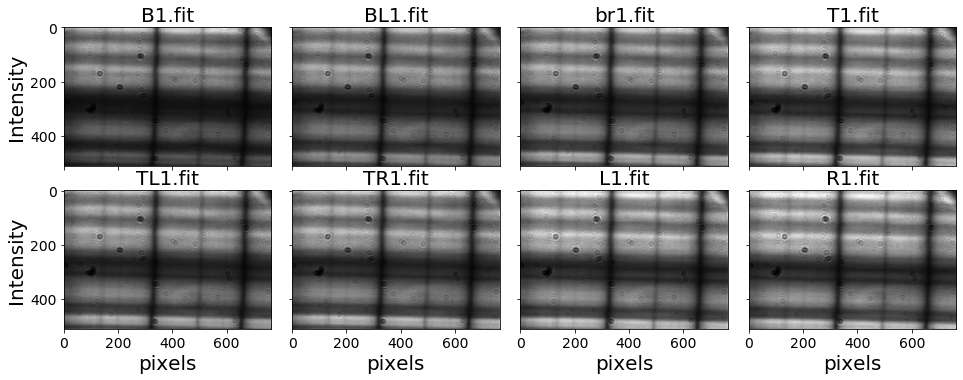

In [38]:
# This cell plots all of your fits images in a grid. 
# The name of each file will be printed on top of each image

fs = 20
fig, ax = plt.subplots(2,4, figsize = (16,6), sharey=True, sharex=True)
for i,file in enumerate(filenames):
    image = fits.getdata(path+file, ext=0)
    if i < 4:
        ax[0][i].imshow(image, cmap='gray')
        ax[0][i].set_title(file, fontsize=fs)
        ax[0][i].tick_params(labelsize=14)
    else:
        ax[1][i-4].imshow(image, cmap='gray')
        ax[1][i-4].set_title(file,  fontsize=fs)
        ax[1][i-4].tick_params(labelsize=14)
        ax[1][i-4].set_xlabel('pixels', fontsize=fs)
        
ax[0][0].set_ylabel('pixels', fontsize=fs)
ax[1][0].set_ylabel('pixels', fontsize=fs)
plt.subplots_adjust(wspace=0.1, hspace=0.)

### Now lets select one file to look at in closer detail.
### We will then select a "slice" of the image in order to plot our spectra.

In [4]:
# Enter the name of the file you wish to look at more closely
selected_file = 'br1.fit'

# Now let's make an object we can plot
selected_image = fits.getdata(path+selected_file, ext=0)

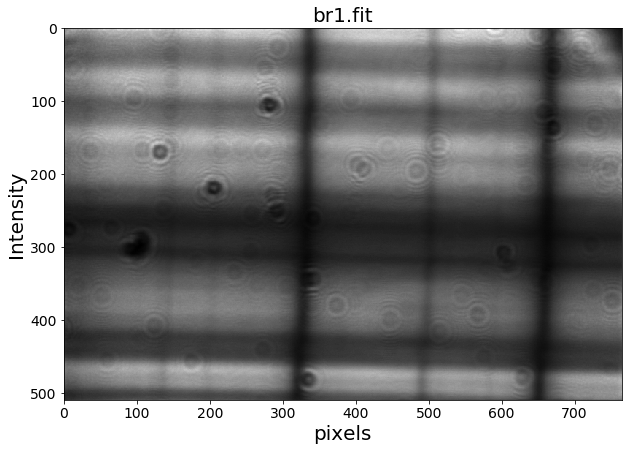

In [37]:
plt.figure(figsize=(10,12))
plt.imshow(selected_image, cmap='gray')
plt.title(selected_file, fontsize=fs)
plt.tick_params(labelsize=14)
plt.xlabel('pixels', fontsize=fs)
plt.ylabel('pixels', fontsize=fs);

### Let's select the "slice"

We now want to select a region of the image that cuts a small (~30-100 vertical pixel by the full horizontal pixel) region of the image. It is important to avoid the circular dust rings as much as possible. More specficially, you do not want to select a region where dust falls on the NaD lines or the water lines! Your TF will help guide you through this if you have questions. 

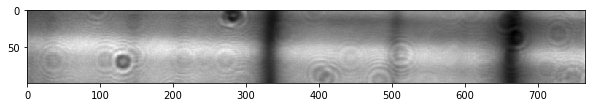

In [6]:
# Type the boundaries of the "slice". 
# You can keep adjusting the bounds until you get a slice you want to use.
# Remember: we want both Na D lines and the Telluric line!
#     Reference the online Solar spectrum (http://bass2000.obspm.fr/solar_spect.php) and compare 
#     with the solar atlas (http://astrosurf.com/spectrohelio/atlas-en.php) to ensure that you include 
#     a water line in your images

#boundaries
low = 100
high = 200

#make the slice
image_slice = selected_image[low:high]

#plot
plt.figure(figsize=(10,12))
plt.imshow(image_slice, cmap='gray');

### Let's plot the spectra of all 8 images using the extracted slices.

In [7]:
#This function normalizes the data to get the data on the same scale.
def norm(data):
    '''
    This function normalizes the selected data for plotting the spectra.
    
    parameters
    ---------
    data: nd-array, slice of fits file 
    
    returns:
    -------
    1d-array, normed intensity of spectra
    '''
    data_cut = data[low:high]
    I_mean = np.mean(data_cut, axis=0)
    I_median = np.median(I_mean)
    data_norm = I_mean/I_median
    return data_norm
    

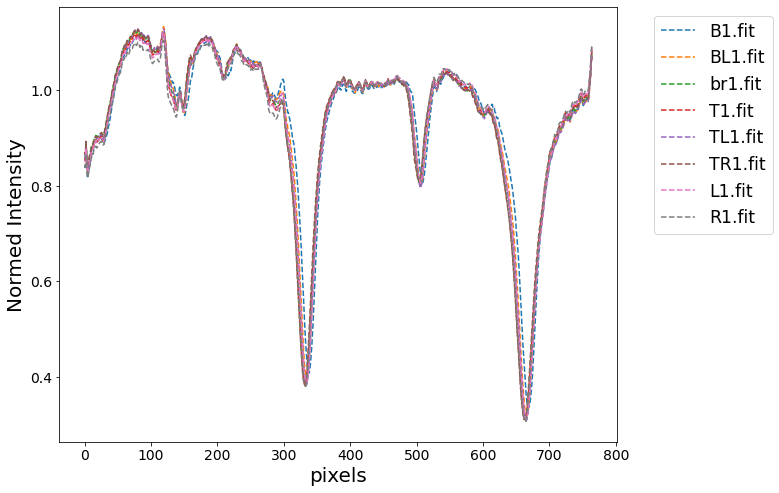

In [8]:
#This cell plots all 8 normalized spectra
fig = plt.figure(figsize = (10,8))
for i,file in enumerate(filenames):
    image      = fits.getdata(path+file, ext=0)
    norm_slice = norm(image)
    plt.plot(norm_slice, linestyle='dashed', label=file)
plt.tick_params(labelsize=14)
plt.xlabel('Pixels', fontsize=fs)
plt.ylabel('Normalized Intensity', fontsize=fs);
plt.legend(bbox_to_anchor=(1.05, 1), fontsize='xx-large');

### Select the two spectra for which you notice the greatest shift.
Rotate through the pairs of spectra by setting spectra_choice_1 and spectra_choice_2 to the various pairs (top and bottom, left and right, top-left and bottom-right, top-right and bottom-left) to determine which pair has the largest shift in pixel space

In [54]:
spectra_choice_1 = 'T1.fit'
spectra_choice_2 = 'B1.fit'

In [55]:
spectrum_1 = norm(fits.getdata(path+spectra_choice_1, ext=0))
spectrum_2 = norm(fits.getdata(path+spectra_choice_2, ext=0))

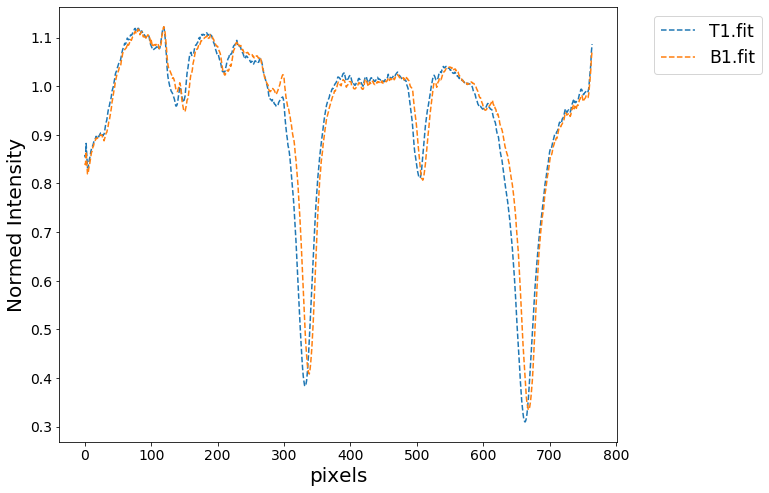

In [56]:
#This cell plots all 8 normed spectra
fig = plt.figure(figsize = (10,8))
plt.plot(spectrum_1, label=spectra_choice_1, linestyle='dashed')
plt.plot(spectrum_2, label=spectra_choice_2, linestyle='dashed')
plt.tick_params(labelsize=14)
plt.xlabel('pixels', fontsize=fs)
plt.ylabel('Normalized Intensity', fontsize=fs);
plt.legend(bbox_to_anchor=(1.05, 1), fontsize='xx-large');

How does it look? Can you see a clear Doppler effect? If not, you can use the next section to looked at the zoomed plots.

# Part 2: Determining $v_\mathrm{rot}$

### First we need to fit the curves of the absorption lines
We do this by selecting a range in pixels that "zooms in" to where our absorption lines are at the minimum.

In [57]:
#We make an array of the pixels to maintain the same pixel values when we zoom in to the curves.
pixels = np.arange(0,spectrum_1.shape[0])

In [58]:
#def zoom_in(data_1, data_2, lowpix_1, highpix_1, lowpix_2, highpix_2):
def zoom_in(data, lowpix, highpix):
    '''
    This function makes a cut, "zoom-in", to the absroption line minimums.
    
    parameters
    ----------
    data_1: 1d-array, normed spectrum
    data_2: 1d-array, normed spectrum shifted from the first
    
    (lowpix and highpix are the pixel boundaries bwteen where our curves lie)
    
    lowpix_1: int, low boundary for first spectrum
    highpix_1: int, high boundary for first spectrum
    
    lowpix_2: int, low boundary for second spectrum
    highpix_2: int, high boundary for second spectrum
    
    returns
    ----------
    1d-array, pixels between where minimums lie
    1d-array, region of spectra where minimums lie
    '''
    return pixels[lowpix:highpix],data[lowpix:highpix]
    
    

In [83]:
### Define your zoomed-in ranges for the left line
NaD_1_b1 = zoom_in(spectrum_1,320,347)
NaD_1_r1 = zoom_in(spectrum_2, 325,350)

In [87]:
### Define your zoomed-in ranges for the right line
NaD_2_b1 = zoom_in(spectrum_1,655,675)
NaD_2_r1 = zoom_in(spectrum_2, 656,675)

In [133]:
### Define your zoomed-in ranges for the Telluric
H2O_b1 = zoom_in(spectrum_1,95,117)
H2O_r1 = zoom_in(spectrum_2,95,117)

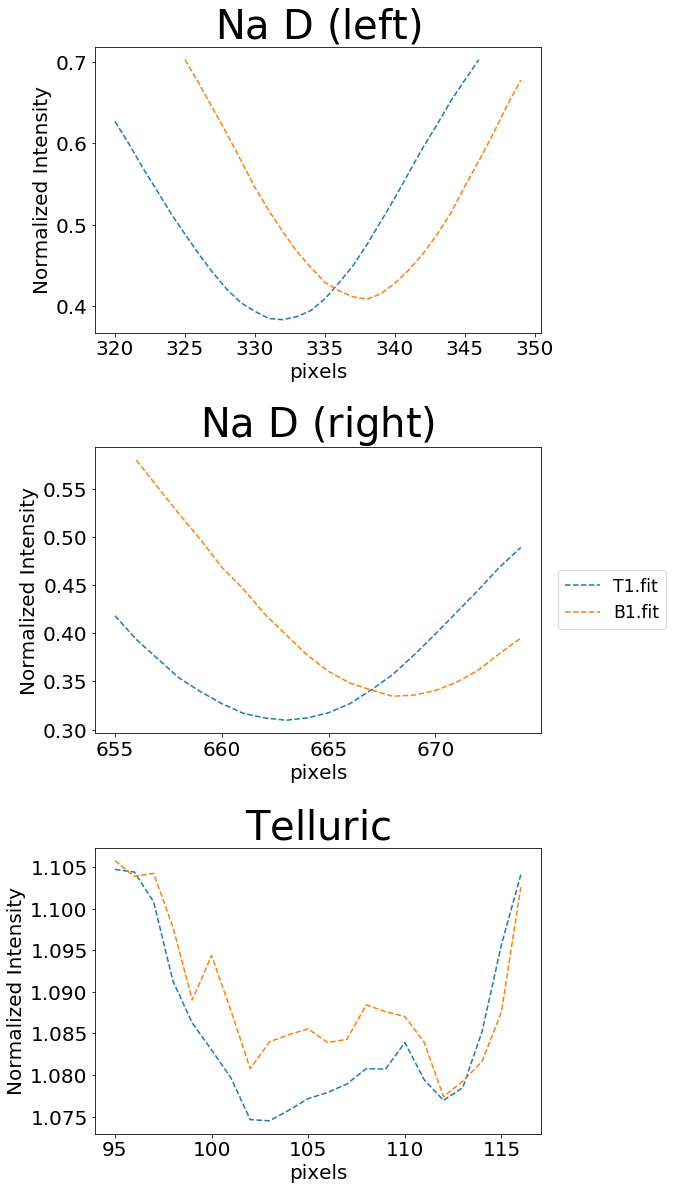

In [134]:
fig, ax = plt.subplots(3,1,figsize = (8,20))
ax[0].plot(NaD_1_b1[0],NaD_1_b1[1], label = spectra_choice_1, linestyle='dashed')
ax[0].plot(NaD_1_r1[0], NaD_1_r1[1], label = spectra_choice_2, linestyle='dashed')
ax[0].set_title('$\mathrm{Na\ D\ (left)}$',fontsize=40)

ax[1].plot(NaD_2_b1[0],NaD_2_b1[1], label = spectra_choice_1, linestyle='dashed')
ax[1].plot(NaD_2_r1[0], NaD_2_r1[1], label = spectra_choice_2, linestyle='dashed')
ax[1].set_title('$\mathrm{Na\ D\ (right)}$',fontsize=40)

ax[2].plot(H2O_b1[0], H2O_b1[1], label = spectra_choice_1, linestyle='dashed')
ax[2].plot(H2O_r1[0], H2O_r1[1], label = spectra_choice_2, linestyle='dashed')
ax[2].set_title('$\mathrm{Telluric}$',fontsize=40)
for i in range(3):
    ax[i].tick_params(labelsize=20)
    ax[i].set_xlabel('pixels', fontsize=fs)
    ax[i].set_ylabel('Normalized Intensity', fontsize=fs);
plt.legend(bbox_to_anchor=(1.3, 2), fontsize='xx-large');
plt.subplots_adjust(hspace=0.4)

### These resemble polynomial functions. We now fit these curves in order to obtain the pixel value where the true minimum occurs. 

In [135]:
# This the polynomial we will use to fit our data
def poly(x,a,b,c):
    '''
    This function reurns a parabola with given input.
    
    parameters
    ----------
    x: 1D-array, the independent variable, in our cse, pixel values
    a,b,c : floats, the coefficients of our parabolic function
    
    returns
    ---------
    1D-array, the normed intensity as a function of pixel values'''
    y = a*x**2 + b*x +c
    return y

#### Fit the curves

In [136]:
from scipy.optimize import curve_fit

In [137]:
#we learned in our first jupyter notebook that it's useful to begin with some guess
guess = [0.5, 1.0, 400]

In [138]:
# We only need the parameters, not the covariance, so we will take index[0] of curve_fit
NaD_1_b1_params = curve_fit(poly, NaD_1_b1[0], NaD_1_b1[1], p0=guess)[0]
NaD_1_r1_params = curve_fit(poly, NaD_1_r1[0], NaD_1_r1[1], p0=guess)[0]

In [139]:
# We only need the parameters, not the covariance, so we will take index[0] of curve_fit
NaD_2_b1_params = curve_fit(poly, NaD_2_b1[0], NaD_2_b1[1], p0=guess)[0]
NaD_2_r1_params = curve_fit(poly, NaD_2_r1[0], NaD_2_r1[1], p0=guess)[0]

In [140]:
# We only need the parameters, not the covariance, so we will take index[0] of curve_fit
H2O_b1_params = curve_fit(poly, H2O_b1[0], H2O_b1[1], p0=guess)[0]
H2O_r1_params = curve_fit(poly, H2O_r1[0], H2O_r1[1], p0=guess)[0]

#### We create a new set of values based on our fit parameters. Rememeber, you may need to make minor adjustments to improve the fit of your curves.

In [141]:
NaD_1_b1_fit = poly(NaD_1_b1[0],NaD_1_b1_params[0], NaD_1_b1_params[1],NaD_1_b1_params[2])
NaD_1_r1_fit = poly(NaD_1_r1[0],NaD_1_r1_params[0], NaD_1_r1_params[1],NaD_1_r1_params[2])

In [142]:
NaD_2_b1_fit = poly(NaD_2_b1[0],NaD_2_b1_params[0], NaD_2_b1_params[1],NaD_2_b1_params[2])
NaD_2_r1_fit = poly(NaD_2_r1[0],NaD_2_r1_params[0], NaD_2_r1_params[1],NaD_2_r1_params[2])

In [143]:
H2O_b1_fit = poly(H2O_b1[0],H2O_b1_params[0], H2O_b1_params[1],H2O_b1_params[2])
H2O_r1_fit = poly(H2O_r1[0],H2O_r1_params[0], H2O_r1_params[1],H2O_r1_params[2])

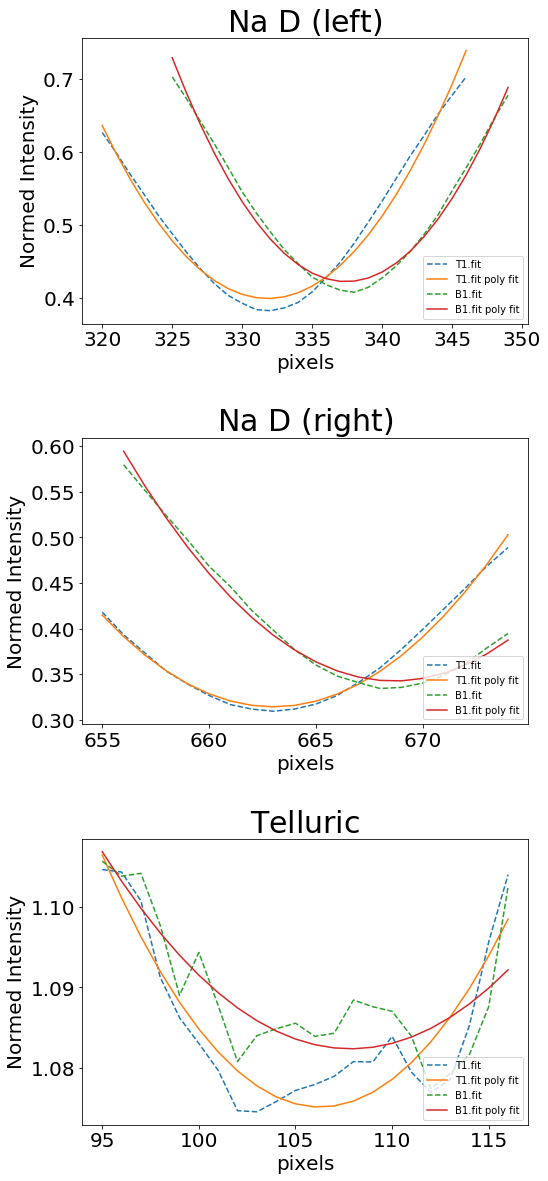

In [144]:
fig, ax = plt.subplots(3,1,figsize = (8,20))
ax[0].plot(NaD_1_b1[0],NaD_1_b1[1], label = spectra_choice_1, linestyle='dashed')
ax[0].plot(NaD_1_b1[0],NaD_1_b1_fit, label = spectra_choice_1+' poly fit')

ax[0].plot(NaD_1_r1[0], NaD_1_r1[1], label = spectra_choice_2, linestyle='dashed')
ax[0].plot(NaD_1_r1[0],NaD_1_r1_fit, label = spectra_choice_2+' poly fit')
ax[0].set_title('$\mathrm{Na\ D\ (left)}$',fontsize=30)

ax[1].plot(NaD_2_b1[0],NaD_2_b1[1], label = spectra_choice_1, linestyle='dashed')
ax[1].plot(NaD_2_b1[0],NaD_2_b1_fit, label = spectra_choice_1+' poly fit')
ax[1].plot(NaD_2_r1[0], NaD_2_r1[1], label = spectra_choice_2, linestyle='dashed')
ax[1].plot(NaD_2_r1[0],NaD_2_r1_fit, label = spectra_choice_2+' poly fit')
ax[1].set_title('$\mathrm{Na\ D\ (right)}$',fontsize=30)

ax[2].plot(H2O_b1[0],H2O_b1[1], label = spectra_choice_1, linestyle='dashed')
ax[2].plot(H2O_b1[0],H2O_b1_fit, label = spectra_choice_1+' poly fit')
ax[2].plot(H2O_r1[0], H2O_r1[1], label = spectra_choice_2, linestyle='dashed')
ax[2].plot(H2O_r1[0],H2O_r1_fit, label = spectra_choice_2+' poly fit')
ax[2].set_title('$\mathrm{Telluric}$',fontsize=30)
for i in range(3):
    ax[i].tick_params(labelsize=20)
    ax[i].set_xlabel('pixels', fontsize=fs)
    ax[i].set_ylabel('Normed Intensity', fontsize=fs)
    ax[i].legend(loc ='lower right');
plt.subplots_adjust(hspace=0.4)

## Now it's time to do our calculations 

In [145]:
def poly_min(a,b):
    '''
    This function returns the minimum values from our polynomial fit parameters.
    
    parameters
    ----------
    a,b: float, the values of the coefficients of our polynomial
    
    returns
    ----------
    float: minimum value
    '''
    return -b/(2*a)

In [146]:
### Get the minimum values
min_NaD_1_b1_fit = poly_min(NaD_1_b1_params[0],NaD_1_b1_params[1])
min_NaD_1_r1_fit = poly_min(NaD_1_r1_params[0],NaD_1_r1_params[1])
min_NaD_2_b1_fit = poly_min(NaD_2_b1_params[0],NaD_2_b1_params[1])
min_NaD_2_r1_fit = poly_min(NaD_2_r1_params[0],NaD_2_r1_params[1])

min_H2O_b1_fit = poly_min(H2O_b1_params[0],H2O_b1_params[1])
min_H2O_r1_fit = poly_min(H2O_r1_params[0],H2O_r1_params[1])

We will calculate our $v_\mathrm{rot}$ in the following manner:
$$\frac{\Delta \lambda}{\lambda}=\frac{v}{c}$$\
$$v_\mathrm{rot}=\frac{c \Delta \lambda}{2 \lambda}$$\
where $\Delta \lambda$ comes from our measuremnts and $\lambda = \lambda_\mathrm{emitted}$

In [147]:
#let's define some constants
c=3e5 # speed of light in km/s
left_emitted = 5895.94 #emission of left NaD in Angstroms
right_emitted = 5889.96 #emission of right NaD in Angstroms

In [148]:
# This cell calculates the conversion factor of pixel to Angstrom
# conversion is 5.97/ the separation between the left and right lines
conversion = 5.97/(min_NaD_2_b1_fit-min_NaD_1_b1_fit)

In [149]:
def V_rot(min_1, min_2, lambda_emitted):
    '''
    This function calculates the rotational velocity given the doopler shift of
    wavelengths at which the absorption lines are at minimum and the emitted absorbtion lines
    
    parameters
    ----------
    min_1, min2: float, the wavelengths of the doppler shifted absorption lines
    lambda_emitted: float, the emitted wavelength
    
    returns
    --------
    float: the rotational velocity
    '''
    
    pixel_separation = np.abs(min_2-min_1)
    Delta_lambda = pixel_separation*conversion
    v = Delta_lambda/lambda_emitted * c
    return (v/2)*units.km/units.s

### And finally we obtain:

#### The rotational velocity

In [150]:
Vrot_left = V_rot(min_NaD_1_b1_fit, min_NaD_1_r1_fit, left_emitted)
Vrot_left

<Quantity 2.56567889 km / s>

In [151]:
Vrot_right = V_rot(min_NaD_2_b1_fit, min_NaD_2_r1_fit, right_emitted)
Vrot_right

<Quantity 2.58970827 km / s>

#### The offset of the Telluric line in pixels -- > this value should be close to zero 

In [159]:
np.round(min_H2O_b1_fit-min_H2O_r1_fit, 6) 

-1.593818